<a href="https://colab.research.google.com/github/jincy-p-janardhanan/SPP-Pneumonia-Net/blob/ml/SPP_Pneumonia_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset from kaggle

Reference site: https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/"

In [ ]:
% cd /content/drive/MyDrive/kaggle
% pwd


/content/drive/MyDrive/kaggle


'/content/drive/MyDrive/kaggle'

In [ ]:
% ls

kaggle.json


In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:41<00:00, 70.7MB/s]
100% 2.29G/2.29G [00:41<00:00, 59.0MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
% ls

chest_xray/  kaggle.json


# SPP-Pneumonia-Net

Copied from [SPP-COVID-Net](https://github.com/SitiRaihanah/SPP-COVID-Net/blob/master/SPP-COVID-Net.py)

## Dependencies

Import dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import glob
import h5py
import math
import time
from tensorflow import keras
from tensorflow.python.client import device_lib
from random import shuffle

In [ ]:
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11905908995244896152
]
2.6.0


## SPP-Pneumonia-Net : Model Architecture

In [ ]:
def SPPCovidNet(class_no,input_height,input_width): 
    input_images=tf.keras.layers.Input(shape=(input_height,input_width,3))

    x = tf.keras.layers.Conv2D(8,(3,3),strides=(1,1),padding='same',use_bias=False)(input_images)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    x = tf.keras.layers.Conv2D(16,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #first triple
    x = tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(16,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #second triple
    x = tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(32,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #third triple
    x = tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2,2),strides=(2,2))(x)

    #fourth triple
    x = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128,(1,1),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    #ending network
    L1 = tf.keras.layers.MaxPooling2D((7,7),strides=(1,1),padding='valid')(x)
    L2 = tf.keras.layers.MaxPooling2D((6,6),strides=(1,1),padding='valid')(x)
    L3 = tf.keras.layers.MaxPooling2D((4,4),strides=(1,1),padding='valid')(x)

    FL1 = tf.keras.layers.Flatten()(L1)
    FL2 = tf.keras.layers.Flatten()(L2)
    FL3 = tf.keras.layers.Flatten()(L3)
    
    x = tf.keras.layers.Concatenate(axis=1)([FL1,FL2,FL3])
    x = tf.keras.layers.Dense(class_no,activation='softmax')(x)

    # Create model.
    model=tf.keras.models.Model(inputs=input_images,outputs=x)
    model.summary()

    return model

## Utility Functions

### Divide dataset to train and test sets

In [ ]:
def divide_data(iter_no,image1,image2,image3,div_data1,div_data2,div_data3):
    print("image1",image1.shape)
    print("image2",image2.shape)
    print("image3",image3.shape)
    print("div_data1",div_data1)
    print("div_data2",div_data2)
    print("div_data3",div_data3)
    
    delete_index1=np.arange(div_data1[iter_no],div_data1[iter_no+1])
    train_data1=np.delete(image1,delete_index1,axis=0)
    test_data1=image1[div_data1[iter_no]:div_data1[iter_no+1]]

    delete_index2=np.arange(div_data2[iter_no],div_data2[iter_no+1])
    train_data2=np.delete(image2,delete_index2,axis=0)
    test_data2=image2[div_data2[iter_no]:div_data2[iter_no+1]]

    delete_index3=np.arange(div_data3[iter_no],div_data3[iter_no+1])
    train_data3=np.delete(image3,delete_index3,axis=0)
    test_data3=image3[div_data3[iter_no]:div_data3[iter_no+1]]

    #combine the data
    train_data=np.concatenate((train_data1,train_data2,train_data3),axis=0)
    test_data=np.concatenate((test_data1,test_data2,test_data3),axis=0)

    return train_data,test_data

### Convert dataset to h5 file

- Convert images to numpy array and save in h5 file
- For faster training <br>
[Github Reference](https://github.com/selvam85/Cat-Dog-Classifier/blob/master/DNN_using_plain_TF_Cat_vs_Dog_classifier_Kaggle_dataset/Convert%20Images%20to%20Numpy%20array%20and%20save%20in%20h5%20fomat%20v2.1.ipynb)

Normalize and write data to h5 file

In [57]:
def normalize_and_write_data_into_h5_file(dest_filepath, filepaths_list, n_px, n_channels = 3):
    
    '''
        This function converts images to numpy arrays and writes the array data into a h5 file.
        
        dest_filepath - the name of the file with full path that is being created
        filepaths_list - source image file paths which is being converted to numpy arrays
        n_px - number of pixels - will be used as image's height and width
        n_channels - 3 for rgb
    '''
    
    data_shape = (len(filepaths_list), n_px * n_px * n_channels)
    dataset_name = "input_data"

    with h5py.File(dest_filepath, 'a') as f:
        
        f.create_dataset(dataset_name, data_shape, np.float32)
        
        for i in range(len(filepaths_list)):
            #if (i+1) % 512 == 0:
            #    print('{}/{} files converted'.format((i+1), len(filepaths_list)))

            filepath = filepaths_list[i]
            img = cv2.imread(filepath)
            img = cv2.resize(img, (n_px, n_px), interpolation=cv2.INTER_CUBIC)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # To convert colormap from BGR to RGB
            
            #Normalize the image - convert the each pixel value between 0 and 1
            img = img / 255
            #Reshape the image - roll it up into a column vector
            img = img.ravel()
            
            #img[None] makes it a proper array instead of rank 1 array
            f[dataset_name][i, ...] = img[None]

Write corresponding labels for each image into the h5 file

In [59]:
def write_labels_into_h5_file(dest_filepath, labels):
    dataset_name = "input_labels"
    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, (len(labels),), np.int8)
        f[dataset_name][...] = labels

Numbers for labelling
- 0: Normal
- 1: Bacterial
- 2: Viral

In [ ]:
def set_label(filepath):
  if 'bacteria' in filepath:
    return 1
  elif 'virus' in filepath:
    return 2
  else:
    return 0

Combined function for converting images and writing labels

In [62]:
def convert_images_to_data_in_h5_file(src_img_filepath, dest_h5_file_path, n_px, n_channels = 3, batch_size = 1024):
    
    # Returns a list of filepaths ending with .jpeg extension in the source directory and its sub-directories
    src_filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(src_img_filepath) for f in filenames if os.path.splitext(f)[1] == '.jpeg']

    # Create Labels based upon the substring contained in the filename
    labels = [set_label(filepath) for filepath in src_filepaths]
    
    #The zip(source_filepaths, labels) combines each element of source_filepaths list 
    #with each element of labels list forming a pair (tuple). t is the list which contains these tuples
    t = list(zip(src_filepaths, labels))

    #Shuffle the list
    shuffle(t)
    
    #Get the shuffled filepaths & labels
    src_filepaths, labels = zip(*t)
    
    #Number of images
    m = len(src_filepaths) 
    n_complete_batches = math.ceil(m / batch_size)
    
    for i in range(n_complete_batches):
        print('Creating file', (i+1))
        
        dest_file_path = dest_h5_file_path + str(i + 1) + ".h5"   
        
        start_pos = i * batch_size
        end_pos = min(start_pos + batch_size, m)
        src_filepaths_batch = src_filepaths[start_pos: end_pos]
        labels_batch = labels[start_pos: end_pos]
        
        normalize_and_write_data_into_h5_file(dest_file_path, src_filepaths_batch, n_px)
        write_labels_into_h5_file(dest_file_path, labels_batch)

## Load data

In [ ]:
# parameters, train pterygium for 250 normal and 250 pterygium - test: 271 normal and 78 pterygium
# covid_19_dir="C:/Users/asyra/Desktop/database/covid19 radiography database/COVID-19"
# normal_dir="C:/Users/asyra/Desktop/database/covid19 radiography database/NORMAL"
# viral_pneumonia_dir="C:/Users/asyra/Desktop/database/covid19 radiography database/Viral Pneumonia"

In [43]:
root_dir = '/content/drive/MyDrive/kaggle/chest_xray/chest_xray/'

In [44]:
src_filepaths = [ root_dir + 'train', root_dir + 'val', root_dir + 'test' ]

In [47]:
% mkdir /content/drive/MyDrive/kaggle/chest_xray/chest_xray/trainh5

In [46]:
% mkdir /content/drive/MyDrive/kaggle/chest_xray/chest_xray/valh5

In [61]:
% mkdir /content/drive/MyDrive/kaggle/chest_xray/chest_xray/testh5

In [50]:
dest_filepaths = [root_dir+'trainh5/train_', root_dir+'valh5/val_', root_dir+'testh5/test_']

In [64]:
n_px = 128
n_channels = 1
for i in range(3):
  tic = time.process_time()
  convert_images_to_data_in_h5_file(src_filepaths[i], dest_filepaths[i], n_px, n_channels)
  toc = time.process_time()
  print('Time taken for creating the h5 file is', (toc-tic)*1000, 'ms')

Creating file 1
Creating file 2
Creating file 3
Creating file 4
Creating file 5
Creating file 6
Time taken for creating the h5 file is 98631.04797900001 ms
Creating file 1
Time taken for creating the h5 file is 298.55792200004316 ms
Creating file 1
Time taken for creating the h5 file is 11648.057994999988 ms


In [69]:
names = ['train', 'validation', 'test']
for i in range(3):
  with h5py.File(dest_filepaths[i]+'1.h5', "r") as f:
      x = f["input_data"][:]
      y = f["input_labels"][:]
      print(names[i], ': x shape =', x.shape, '| y shape =', y.shape)

train : x shape = (1024, 49152) | y shape = (1024,)
validation : x shape = (16, 49152) | y shape = (16,)
test : x shape = (624, 49152) | y shape = (624,)


### preview images

Sample X-ray images from the train set

In [ ]:
train_dir = os.path.join(rootdir, "train_images/train_images")
filenames = os.listdir(train_dir)

In [ ]:
filenames

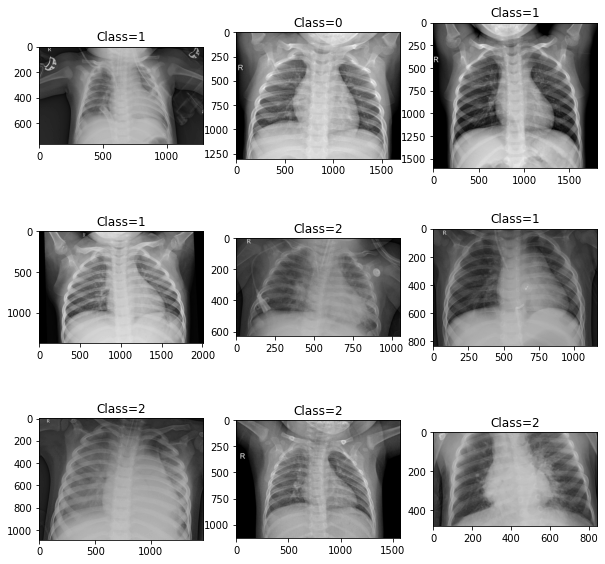

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        idx = 3*i+j
        filename = os.path.join(train_dir, filenames[idx+10])
        label = labels[idx+10]
        plt.subplot(3,3,idx+1)
        im = plt.imread(filename, 'jpg')
        plt.imshow(im, cmap=plt.gray())
        plt.title('Class='+str(label))

In [ ]:
class_no=3
image_size=256

In [ ]:
# covid_19_name=my_read.get_all_non_hidden_files(covid_19_dir,'png','~')
# normal_name=my_read.get_all_non_hidden_files(normal_dir,'png','~')
# viral_pneumonia_name=my_read.get_all_non_hidden_files(viral_pneumonia_dir,'png','~')

In [ ]:
for i in range(len(filenames)):
    read_image=cv2.imread(filenames[i])
    read_image=cv2.resize(read_image,(image_size,image_size))
    read_image=read_image.reshape(1,read_image.shape[0],read_image.shape[1],read_image.shape[2])
    # if i==0:
    #     covid_image=np.copy(read_image)
    # else:
    #     covid_image=np.append(covid_image,read_image,axis=0)

error: ignored

In [ ]:
for i in range(len(covid_19_name)):
    read_image=cv2.imread(covid_19_name[i])
    read_image=cv2.resize(read_image,(image_size,image_size))
    read_image=read_image.reshape(1,read_image.shape[0],read_image.shape[1],read_image.shape[2])
    if i==0:
        covid_image=np.copy(read_image)
    else:
        covid_image=np.append(covid_image,read_image,axis=0)

for i in range(len(normal_name)):
    read_image=cv2.imread(normal_name[i])
    read_image=cv2.resize(read_image,(image_size,image_size))
    read_image=read_image.reshape(1,read_image.shape[0],read_image.shape[1],read_image.shape[2])
    if i==0:
        normal_image=np.copy(read_image)
    else:
        normal_image=np.append(normal_image,read_image,axis=0)

for i in range(len(viral_pneumonia_name)):
    read_image=cv2.imread(viral_pneumonia_name[i])
    read_image=cv2.resize(read_image,(image_size,image_size))
    read_image=read_image.reshape(1,read_image.shape[0],read_image.shape[1],read_image.shape[2])
    if i==0:
        pneumonia_image=np.copy(read_image)
    else:
        pneumonia_image=np.append(pneumonia_image,read_image,axis=0)

fold_no=5
covid_div_data=[0]
normal_div_data=[0]
pneumonia_div_data=[0]
for i in range(fold_no):
    covid_div_data.append(int((i+1)*len(covid_image)/fold_no))
    normal_div_data.append(int((i+1)*len(normal_image)/fold_no))
    pneumonia_div_data.append(int((i+1)*len(pneumonia_image)/fold_no))
    
#create one hot for train data
covid_label=np.zeros((covid_image.shape[0],class_no))
covid_label[:,0]=1

normal_label=np.zeros((normal_image.shape[0],class_no))
normal_label[:,1]=1

pneumonia_label=np.zeros((pneumonia_image.shape[0],class_no))
pneumonia_label[:,2]=1
print("finish loading data and labels")

## Model Training

In [ ]:
accuracy=[]
for iter_no in range(fold_no):
    print(str(iter_no)+" fold!")
    train_images,test_images=divide_data(iter_no,covid_image,normal_image,pneumonia_image,covid_div_data,normal_div_data,pneumonia_div_data)
    train_labels,test_labels=divide_data(iter_no,covid_label,normal_label,pneumonia_label,covid_div_data,normal_div_data,pneumonia_div_data)

    print("train_images",train_images.shape)
    print("train_labels",train_labels.shape)
    print("test_images",test_images.shape)
    print("test_labels",test_labels.shape)

    checkpoint_path="test/cp.ckpt"
    checkpoint_dir=os.path.dirname(checkpoint_path)

    #create checkpoint callback
    cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,verbose=1)
    input_height,input_width = image_size,image_size
    model=SPPCovidNet(class_no,input_height,input_width)
    epoch_no=100
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
    H=model.fit(x=train_images,y=train_labels,epochs=epoch_no,batch_size=64,verbose=2)

    # plot the training loss and accuracy
    N = np.arange(0,epoch_no)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy (Simple NN)")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show(block=False)
    plt.pause(1)

    loss,acc=model.evaluate(test_images,test_labels,batch_size=1,verbose=2)
    print("current accuracy:",acc)
    accuracy.append(acc)

    tf.keras.backend.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8636591832379370538
]
2.6.0


NameError: ignored

In [ ]:
accuracy=np.array(accuracy)
print("accuracy",accuracy)
mean_accuracy=np.mean(accuracy,axis=0)
print("mean_accuracy",mean_accuracy)